# Example of using Quantum computing on the breast cancer dataset

The QSVM algorithm takes the classical machine learning algorithm and performs the support vector machine on a quantum circuit in order to be efficiently processed on a quantum computer.

In [1]:
!pip install qiskit
!pip install qiskit-terra
from IPython.display import clear_output
clear_output()

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('dark_background')

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.datasets import load_breast_cancer 

from qiskit.aqua import MissingOptionalLibraryError
from qiskit import Aer
from qiskit.circuit.library import ZZFeatureMap
from qiskit.aqua import aqua_globals
from qiskit.utils import QuantumInstance
from qiskit.aqua.algorithms import QSVM, SklearnSVM
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name

seed = 42
aqua_globals.random_seed = seed

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: The variable qiskit.aqua.aqua_globals is deprecated. It was moved/refactored to qiskit.utils.aqua_globals (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>


In [3]:
#Google Mount
from google.colab import drive
drive.mount('/content/drive/')
%cd drive/My\ Drive/Classes/Covid_19_project/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Classes/Covid_19_project


In [4]:
!pwd

/content/drive/My Drive/Classes/Covid_19_project


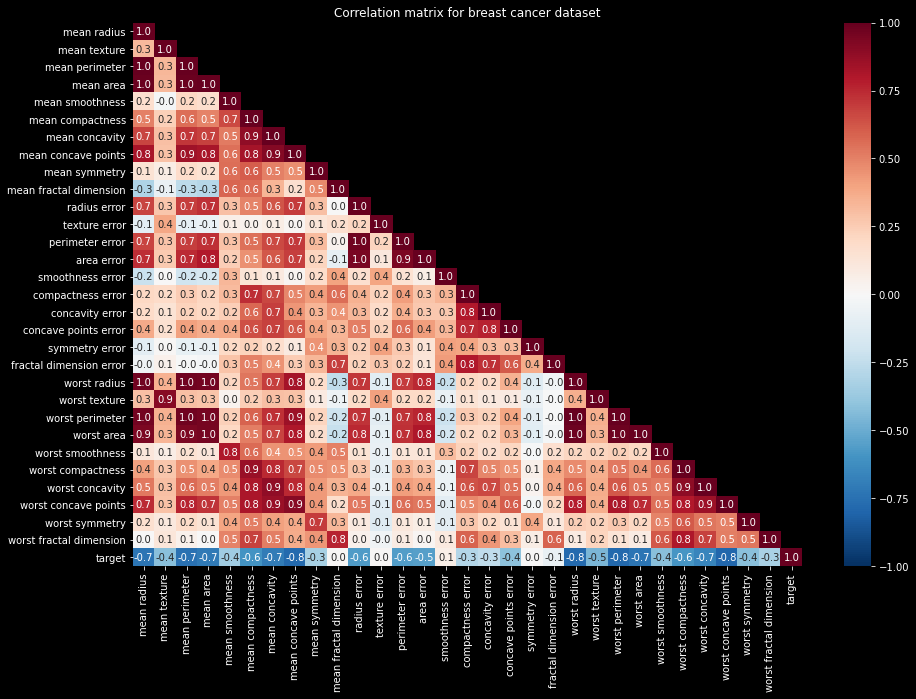

In [5]:
 # loading data
cancer = load_breast_cancer()
data = pd.DataFrame(np.c_[cancer['data'], cancer['target']],
                  columns= np.append(cancer['feature_names'], ['target']))

# Create correlation matrix
corr_mat = data.corr()

# Create mask
mask = np.zeros_like(corr_mat, dtype=np.bool)
mask[np.triu_indices_from(mask, k=1)] = True

# Plot heatmap
plt.figure(figsize=(15, 10));
sns.heatmap(corr_mat, annot=True, fmt='.1f',
            cmap='RdBu_r', vmin=-1, vmax=1,
            mask=mask);
plt.title('Correlation matrix for breast cancer dataset');
plt.savefig('images/qsvm/cormatrix_cancer_df.png');

Since number of features in the actual dataset is more than 2, I will plot a PCA (Principal Compoenent Analysis) of the datapoints scatter.

In [6]:
#been taken and modified from
#(C) Copyright IBM 2018, 2020.

def breast_cancer(training_size, test_size, n, plot_data=False):
    """ returns breast cancer dataset """
    class_labels = [r'malignant', r'benign']
    data, target = datasets.load_breast_cancer(return_X_y=True)
    sample_train, sample_test, label_train, label_test = \
        train_test_split(data, target, test_size=0.2, random_state=42)

    # Now we standardize for gaussian around 0 with unit variance
    std_scale = StandardScaler().fit(sample_train)
    sample_train = std_scale.transform(sample_train)
    sample_test = std_scale.transform(sample_test)

    # Now reduce number of features to number of qubits
    pca = PCA(n_components=n).fit(sample_train)
    sample_train = pca.transform(sample_train)
    sample_test = pca.transform(sample_test)

    # Scale to the range (-1,+1)
    samples = np.append(sample_train, sample_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    sample_train = minmax_scale.transform(sample_train)
    sample_test = minmax_scale.transform(sample_test)

    # Pick training size number of samples from each distro
    training_input = {key: (sample_train[label_train == k, :])[:training_size]
                      for k, key in enumerate(class_labels)}
    test_input = {key: (sample_test[label_test == k, :])[:test_size]
                  for k, key in enumerate(class_labels)}

    if plot_data:
        try:
            import matplotlib.pyplot as plt
            import seaborn as sb
        except ImportError as ex:
            raise MissingOptionalLibraryError(
                libname='Seaborn',
                name='breast_cancer',
                pip_install='pip install seaborn') from ex
        for k in range(0, 2):
            sb.scatterplot(x=sample_train[label_train == k, 0][:training_size], 
                           y=sample_train[label_train == k, 1][:training_size])
        plt.title('PCA dim. reduced Breast cancer dataset')
        plt.savefig('images/qsvm/pca_cancer_df.png');

    return sample_train, training_input, test_input, class_labels

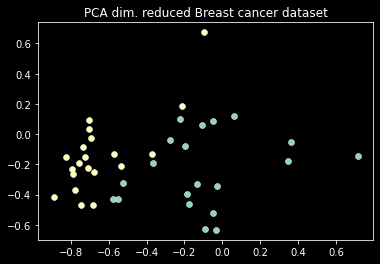

In [7]:
#learned kernel

feature_dim = 2
sample_total, training_input, test_input, class_labels = breast_cancer(
    training_size=20,
    test_size=10,
    n=feature_dim,
    plot_data=True
)

Quantum SVM

In [8]:
feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement='linear')
qsvm = QSVM(feature_map, training_input, test_input)

backend = Aer.get_backend('qasm_simulator')

quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)

/usr/local/lib/python3.7/dist-packages/qiskit/aqua/algorithms/classifiers/qsvm/qsvm.py:104: DeprecationWarning: The package qiskit.aqua.algorithms.classifiers is deprecated. It was moved/refactored to qiskit_machine_learning.algorithms.classifiers (pip install qiskit-machine-learning). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  'qiskit-machine-learning')


Testing Accuracy: 75.0%
CPU times: user 7.43 s, sys: 196 ms, total: 7.62 s
Wall time: 7.53 s


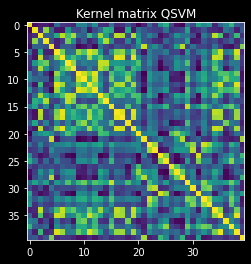

In [9]:
%%time
result = qsvm.run(quantum_instance)

print(f"Testing Accuracy: {result['testing_accuracy'] * 100}%")

kernel_matrix = result['kernel_matrix_training']
plt.imshow((np.asmatrix(kernel_matrix)), interpolation='nearest', origin='upper');
plt.title('Kernel matrix QSVM')
plt.savefig('images/qsvm/qsvm_cancer_result.png');

Classical SVM

Testing Accuracy: 95.0%
CPU times: user 169 ms, sys: 153 ms, total: 321 ms
Wall time: 211 ms


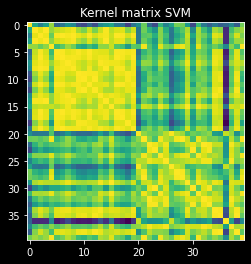

In [10]:
%%time
result = SklearnSVM(training_input, test_input).run()
print(f"Testing Accuracy: {result['testing_accuracy'] * 100}%")

kernel_matrix = result['kernel_matrix_training']
plt.imshow(np.asmatrix(kernel_matrix), interpolation='nearest', origin='upper');
plt.title('Kernel matrix SVM')
plt.savefig('images/qsvm/svm_cancer_result.png');